<h1> Document Classification and Topic Modeling from arXiv Paper Abstracts <h1>
    
<h2> Project Structure </h2>

<ol style="list-style-type: upper-roman;">
    <li> Introduction </li>
    <li> Data </li>
    <li> Text Preprocessing </li>
    <li> Models </li>
    <li> Evaluation </li>
    <li> Potential Improvements </li>
</ol>

<h2 > I. Introduction </h2>
    
<p> In this project, I perform text classification on paper abstracts in Cornell University's arXiv database, a popular database of STEM papers. The objective is the following: </p>
    
<p style="text-align:center"> Given M documents constructed from a vocabulary of V unique words, find a set of K topics from which words in documents are drawn.</p>

<p> This statement of the problem assumes that documents may consist of terms that are borrowed from <b>one or more</b> of the K topics. Since we can assign one or more topic labels to each document, this a type of <i>soft clustering</i> problem. In hard clustering, we are constrained to assigning only one topic label per document. </p>
    
<p> The most intuitive way I can think of motivating this assumption is to convince yourself that academics working in different subject areas are speaking different languages. If we consider a term like "entropy," we know that it has use for at least two groups of people: physicists interested in thermodynamics, and statisticians interested in properties of probability distributions. By understanding associations to other words in the document, like "system" or "random", we can discriminate which topic the term "entropy" was more likely to have been drawn from. </p>

<p> In Data, I perform exploratory data analysis on the entire set of papers, then select the subset published from January 1st, 2019 to August 14th, 2020. 

<p> In Text Preprocessing, I explain how I transform raw text documents into vectors suitable for comparison and computation. I discuss how to convert raw text into a set of "tokens" suitable for further analysis, and only keeping tokens that are necessary to convey meaning in documents.</p>

<p>In Models, I discuss how Latent Semantic Analysis and Latent Dirichlet Allocation work as approaches to our soft classification problem.</p>

<p>In Evaluation, I discuss the results of the LSA and LDA models.  </p>

<p>Lastly, in Potential Improvements, I summarize the shortcomings of the methods used. I address some other interesting questions that arise from the earlier semantic analysis.</p>

<h2> II. Data </h2> 

The data can be found on Kaggle <a href="https://www.kaggle.com/Cornell-University/arxiv"> here</a>. 
    
In my EDA, I answer the following questions:

1. How many papers are in the dataset?
2. What does the metadata for a paper look like?
3. What are the top categories as labelled by arXiv?
4. Who are the top authors?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.bag as db
from dask.distributed import Client
import json
client = Client()
papers = db.read_text('arxiv-metadata-oai-snapshot-2020-08-14.json').map(json.loads)

<h3> Count </h3>

In [3]:
papers.count().compute()

1747307

<h3> Example </h3>

In [4]:
print(json.dumps(papers.take(10)[4], indent=1))

{
 "id": "0704.0005",
 "submitter": "Alberto Torchinsky",
 "authors": "Wael Abu-Shammala and Alberto Torchinsky",
 "title": "From dyadic $\\Lambda_{\\alpha}$ to $\\Lambda_{\\alpha}$",
 "comments": null,
 "journal-ref": "Illinois J. Math. 52 (2008) no.2, 681-689",
 "doi": null,
 "report-no": null,
 "categories": "math.CA math.FA",
 "license": null,
 "abstract": "  In this paper we show how to compute the $\\Lambda_{\\alpha}$ norm, $\\alpha\\ge\n0$, using the dyadic grid. This result is a consequence of the description of\nthe Hardy spaces $H^p(R^N)$ in terms of dyadic and special atoms.\n",
 "versions": [
  {
   "version": "v1",
   "created": "Mon, 2 Apr 2007 18:09:58 GMT"
  }
 ],
 "update_date": "2013-10-15",
 "authors_parsed": [
  [
   "Abu-Shammala",
   "Wael",
   ""
  ],
  [
   "Torchinsky",
   "Alberto",
   ""
  ]
 ]
}


<h3> ArXiv Category Taxonomy</h3>

In [168]:
from bs4 import BeautifulSoup
import requests

taxonomy_lk = 'https://arxiv.org/category_taxonomy'
text = requests.get(taxonomy_lk).text
soup = BeautifulSoup(text, 'html.parser')
subjects = soup.find_all('h4')[1:]
tax = {}
for subj in subjects:
    abbrev, name = subj.contents
    tax[abbrev.strip()] = name.contents[0].strip('()')
tax = pd.DataFrame(tax.values(), index=tax.keys(), columns=['subject'])
tax.loc['stat.ML'][0] = "Machine Learning (STAT)"
tax.loc['cs.LG'][0] = "Machine Learning (CS)"
tax.head()

,subject
cs.AI,Artificial Intelligence
cs.AR,Hardware Architecture
cs.CC,Computational Complexity
cs.CE,"Computational Engineering, Finance, and Science"
cs.CG,Computational Geometry


<h3> Top Categories </h3>

In [161]:
def top_k_plot(df, k=10):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    fig.tight_layout()
    ax.set_title('Top {} Categories'.format(k), fontsize='x-large')
    ax.barh(df['subject'][:k], df['count'][:k], edgecolor='black')
    ax.set_xlabel("Frequency", fontsize='large')
    ax.set_ylabel("Category", fontsize='large')
    plt.savefig("topk.png")
    plt.show()

In [112]:
ctgry_counts = (papers.map(lambda x: x['categories'].split(' '))
       .flatten()
       .frequencies(sort=True)
       .compute())
cc_df = pd.DataFrame(ctgry_counts, columns=['cat', 'count']).set_index('cat')
cc_df = tax.join(cc_df).sort_values('count', ascending=False)

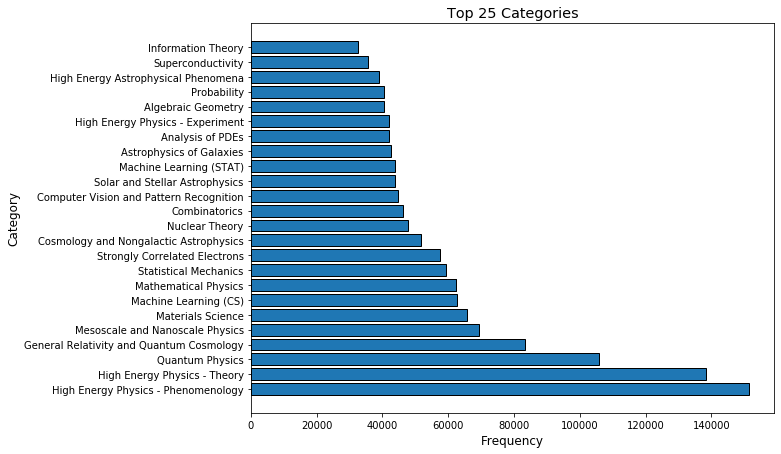

In [166]:
%matplotlib inline
top_k_plot(cc_df, 25)

<h3> Top Authors </h3>

In [71]:
def author_keys(x):
    return [' '.join(author[:2]).strip() for author in x['authors_parsed']]

In [10]:
(papers.map(lambda x: author_keys(x))
        .flatten()
        .frequencies(sort=True)
        .topk(10, key=1).compute())

[('Zhang Y.', 1616),
 ('Zhang L.', 1096),
 ('Li Y.', 1041),
 ('Wang Y.', 1039),
 ('Wang J.', 1002),
 ('CMS Collaboration', 973),
 ('Gao Y.', 952),
 ('Liu X.', 884),
 ('ATLAS Collaboration', 884),
 ('Yang Z.', 853)]

<h3> Subset: 2019-Present </h3>

<p> We now examine the subset of papers published from January 2019 to August 2020 (305,613 papers total). </p>

In [11]:
strip = lambda x: {
    'id': x['id'],
    'title': x['title'],
    'category':x['categories'],
    'abstract':x['abstract']}
last_version = lambda x: x['versions'][-1]['created']
paper_list = papers.filter(lambda x: int(last_version(x).split(' ')[3]) > 2018).map(strip).compute()
paper_df = pd.DataFrame(paper_list)
paper_df.head()

,id,title,category,abstract
0,0704.1445,Deformed Wigner crystal in a one-dimensional q...,cond-mat.str-el cond-mat.mes-hall,The spatial Fourier spectrum of the electron...
1,0705.0033,Ergodic Theory: Recurrence,math.DS,We survey the impact of the Poincar\'e recur...
2,0705.0344,Unifying derived deformation theories,math.AG,We develop a framework for derived deformati...
3,0705.0825,Einstein's Theory of Gravity in the Presence o...,gr-qc astro-ph hep-th,The mysterious `dark energy' needed to expla...
4,0705.2562,Anthropic prediction in a large toy landscape,hep-th,The successful anthropic prediction of the c...


In [12]:
dd = {}
for subj in paper_df.category.values:
    for s in subj.split(" "):
        if s not in dd:
            dd[s] = 0
        else:
            dd[s] += 1
recent_topics = sorted(dd.items(), key= lambda x:x[1], reverse=True)
recent_topics = pd.DataFrame(recent_topics, columns=['subject', 'count']).set_index('subject')
recent_topics = tax.join(recent_topics).sort_values('count', ascending=False)

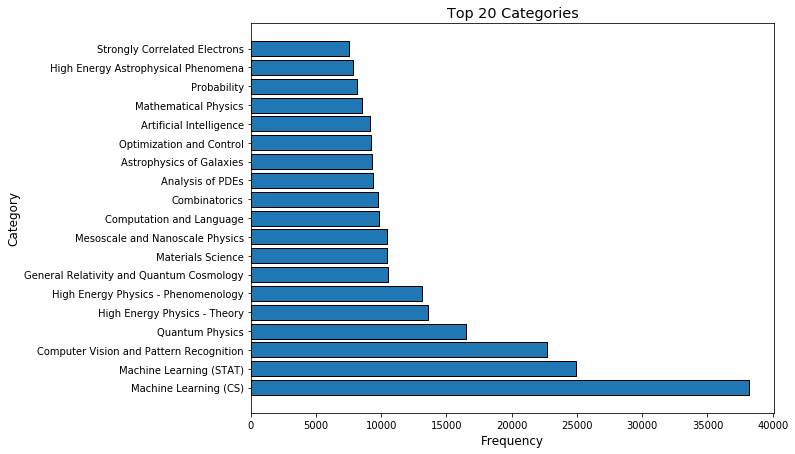

In [167]:
%matplotlib inline
top_k_plot(recent_topics, 20)

<h2> III.  Text Preprocessing </h2>

<h3> Terminology</h3>

<ul>
    <li> Term: a meaningful substring in a document
    <li> Document: text string
    <li> Corpus: a collection of documents
    <li> Vocabulary: the unique collection of terms in a corpus
</ul>
    
 
<p> Abstracts from arXiv are documents. A list of abstracts can be considered a corpus. In these new terms, we can succinctly state the goal of the text preprocessing stage as reducing document strings down to only elements of the vocabulary, $V$. </p>

<p>Three more steps are performed to reduce the size of $V$:</p> 
    
1. Tokenization
2. Lemmatization
3. Removal of Stop Words

<h3> Tokenization </h3>

<p>Tokenization is the process of chopping a string document into a set of <i>tokens</i>, or which symbols, that are representative of that document. </p>

For example:
<table style='font-size:12pt'>
    <tr>
        <th>Document</th>
        <th colspan="1">Tokenization</th>
    </tr>
    <tr>
        <td>
        "Would you like to eat soup?"
        </td>
        <td>
           ["would", "you", "like", "to", "eat", "soup", "?"]
        </td>
    </tr>
</table>

<p> Tokenization of a document varies by task. Some tasks require fine details about context. A chatbot, for example, responding to sequences of user-submitted documents might need the question mark symbol included to understand that the user is asking a question. </p>
    
<p>In our specific task, we are not interested in a particular type of substring in the document: mathematical equations. So, our tokenization requires that we only accept substrings in a document that are not encapsulated by two dollar sign symbols.</p>

<h3> Lemmatization </h3>

Languages have defined sets of rules that transform words from a root form to a new form containing an additional prefix or suffix to modify word features such as tense, number, or plurality. A simple example is Spanish, where the infinitive form of (regular) "-AR" verbs like "comprar" are transformed by concatenating suffixes from the set $\{-o,-as, \dots, -an\}$.
    
<p>In linguistics, the root form of a word is called a <i> lemma </i>, and the transformed version is said to be <i> inflected </i>. Lemmatization takes all inflected forms of a word to their lemma, thus reducing the size of our vocabulary.</p>
For example: 

<table style='font-size:12pt'>
    <tr>
        <th>Document</th>
        <th colspan="1">Lemmatization</th>
    </tr>
    <tr>
        <td>
        "We shopped at several stores this afternoon"
        </td>
        <td>
           ["we", "<b>shop</b>", "at", "several", "<b>store</b>", "this", "afternoon"]
        </td>
    </tr>
</table>

<h3> Removal of Stop Words </h3>

<p> After tokens are reduced to their lemmas, <i>stop words</i>, words used commonly enough to be deemed unimportant in our analysis, are removed. These removable words include some common classes of words like pronouns or determiners, which reveal little information about the conceptual content of documents.</p>

For example: 

<table style="font-size: 12pt">
    <tr>
        <th>Document</th>
        <th colspan="1">Stop Words Removed</th>
    </tr>
    <tr>
        <td>
        "We shopped at several store this afternoon"
        </td>
        <td>
           ["shopped", "several", "store", "afternoon"]
        </td>
    </tr>
</table>

<h3> In Terms of Fomal Languages </h3>
    
<p>The framework of formal language theory helps us understand text preprocessing in general terms. We can define </p>

- **Alphabet** ($\Sigma$): a set of symbols 
- **Words** ($\Sigma^*$): the free monoid on the alphabet $\Sigma$
- **Language** (L): a subset of words $L\subset \Sigma^*$
</ul>

    
<p> An alphabet $\Sigma$, along with an associative operation called "concatenation" (+), and an identity element (the empty string, $\epsilon$) forms a monoid. We can then define  the set of all possible concatenations of a finite sequence of elements from $\Sigma$ as the free monoid of $\Sigma$. Our task in selecting a vocabulary $V$ from earlier can now be stated as finding a formal language, $L$, defined on an alphabet, $\Sigma$, suitable for our task. </p>

In [14]:
import re
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))

In [15]:
def tokenize(txt):
    txt = txt.strip()
    txt = txt.replace('\n', ' ')
    txt = re.sub(r'\$(.*?)\$', '', txt) 
    txt = re.sub(r'[0-9]', '', txt)     
    txt = re.sub(r'[^a-zA-Z ]+', '', txt)
    tokens = txt.lower().split(' ')
    return [token for token in tokens if len(token) > 0]

In [16]:
def remove_stop(tokens):
    accepted = []
    for w in tokens:
        if (w not in stop_words):
            accepted.append(w)
    return accepted

In [17]:
class Tokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = [self.wnl.lemmatize(t) for t in tokenize(doc)]
        return remove_stop(tokens)

<h3> Example </h3>

<p>We can take a very ugly document from our corpus to show the result of applying the three preprocessing steps.</p>

In [169]:
eg = paper_df.abstract[20]
eg

'  Let $R$ be a commutative $k-$algebra over a field $k$. Assume $R$ is a\nnoetherian, infinite, integral domain. The group of $k-$automorphisms of\n$R$,i.e.$Aut_k(R)$ acts in a natural way on $(R-k)$.In the first part of this\narticle, we study the structure of $R$ when the orbit space $(R-k)/Aut_k(R)$ is\nfinite.We note that most of the results, not particularly relevent to fields,\nin [1,\\S 2] hold in this case as well. Moreover, we prove that $R$ is a field.\nIn the second part, we study a special case of the Conjecture 2.1 in [1] : If\n$K/k$ is a non trivial field extension where $k$ is algebraically closed and\n$\\mid (K-k)/Aut_k(K) \\mid = 1$ then $K$ is algebraically closed. In the end, we\ngive an elementary proof of [1,Theorem 1.1] in case $K$ is finitely generated\nover its prime subfield.\n'

In [170]:
eg_tok = tokenize(eg)
" ".join(eg_tok)

'let be a commutative algebra over a field assume is a noetherian infinite integral domain the group of automorphisms of ie acts in a natural way on in the first part of this article we study the structure of when the orbit space is finitewe note that most of the results not particularly relevent to fields in s hold in this case as well moreover we prove that is a field in the second part we study a special case of the conjecture in if is a non trivial field extension where is algebraically closed and then is algebraically closed in the end we give an elementary proof of theorem in case is finitely generated over its prime subfield'

In [171]:
" ".join(remove_stop(eg_tok))

'let commutative algebra field assume noetherian infinite integral domain group automorphisms ie acts natural way first part article study structure orbit space finitewe note results particularly relevent fields hold case well moreover prove field second part study special case conjecture non trivial field extension algebraically closed algebraically closed end give elementary proof theorem case finitely generated prime subfield'

<h2>IV. Models </h2>


<p>The corpus is now ready to be transformed into a matrix of document vectors that will be acceptable for modeling. In the above preprocessing, I took mathematical formulas (or, any characters placed between two dollar signs) to be  to be "noise" that should be removed from the data. </p>
    
    
<p>We can further reduce noise in the dataset by removing words that yield little information. Two more methods are employed to cut down the size of our vocabulary to $N$ terms.</p>

1. Using min_df to remove words that appear in less than (min_df)\% of the documents
2. Using max_df to remove words that appear more than (max_df)\% of the documents

<p>The first method removes words that have very poor representation in the corpus. This is clearly a good goal for our task, as we do not need very niche terms from some esoteric topic like Computational Geometry to understand widely represented topics in the corpus like statistical learning and ML algorithms.</p>
    

<p>The second method can be understood as the removal of "corpus-specific" stop words. Since the documents in this specific corpus are scientific vocabulary terms, we might view words like "equation" or "result," which are universally used across different scientific topics, as giving little information that is helpful in discriminating between topics. </p>


<p>Now, we can formally define the matrix we use for further analysis of the corpus.</p>

<p>Let $V$ be the vocabulary, where $|V|=N$. Consider a corpus of $M$ documents $D=\{d_1, \dots, d_M\}$, where $d_i\in \mathbb{R}^N$.</p>

<p>We need to introduce three statistics : the term frequency (TF), document frequency (DF), and inverse document frequency (IDF):</p>

<p style="text-decoration: underline;">TF </p>

tf$(t, d): V \times D \to \mathbb{R}$ defined by 

$$\text{tf}(t,d) = f_{t,d} = \text{# of occurrences of t in d}$$


<p style="text-decoration: underline;">DF </p>

df$(t, d): V \times D \to \mathbb{N}$ defined by 

$$n_t = |\{d \in D \mid t \in d\}| $$


<p style="text-decoration: underline;">IDF </p>

idf$(t, D): V \to \mathbb{R}$ defined by 

$$\text{idf}(t,D) = \log\left(\frac{N}{n_t}\right) = - \log\left(\frac{n_t}{N}\right)$$


Then, define the $\textit{term-document TF-IDF matrix}$ $X\in \mathbb{R}^{NXM}$ as

$$X = (\text{tf}(t,d) \times \text{idf}(t,D))_{t\in V, d\in D}$$



<!-- ### Information Theory

<font style="font-family: Baskerville; font-size: 14pt">

Full disclosure that this is a tangent. As an aside, I wanted to understand the concept of "divergence" between between two distributions $P$ and $Q$. A popular measure of divergence is the Kullback-Leibler divergence $D( P \| Q)$ the difference between the "cross-entropy" and "entropy" of a random variable:
    
$$D( P \| Q) = H(P, Q) - H(P).$$
    
A reader that is versed in information theory might have noticed that there is something special about the IDF function. We can view the conditional probability of observing term $t$ in the corpus as the relative document frequency:
    
$$P(t \mid D) = \frac{n_t}{N}$$ -->

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

<h3> Vectorization </h3>

In [24]:
count_v = CountVectorizer(tokenizer=Tokenizer(),
                                   min_df=0.02,
                                   max_df=0.5)
X_tf = count_v.fit_transform(paper_df['abstract'])

In [25]:
tfidf_v = TfidfVectorizer(tokenizer=Tokenizer(),
                                   min_df=0.02,
                                   max_df=0.5)
X_tfidf = tfidf_v.fit_transform(paper_df['abstract'])

<h3> Latent Semantic Analysis (LSA) </h3>

<h4 style="font-weight: bolder;"> The SVD </h4>

Given $N$ terms in a corpus of $M$ documents, the document-term TF-IDF matrix is a real matrix $X\in \mathbb{R}^{M X N}$ which can be decomposed into a set of singular values $\sigma_1 \ge \dots \ge \sigma_d \ge 0$, left-singular vectors $\mathbf{u_1}, \dots, \mathbf{u_M}$ and right-singular vectors $\mathbf{v_1}, \dots, \mathbf{v_N}$ such that

$$ X = U \Sigma V^T = \begin{bmatrix} | & & | \\  \mathbf{u_1} & \dots & \mathbf{u_M} \\ | & & |  \end{bmatrix}    
\begin{bmatrix} D & \mathbf{0}  \\ \mathbf{0} & 0 \end{bmatrix}     
\begin{bmatrix} - & \mathbf{v_1}^T & - \\ & \vdots & \\ - & \mathbf{v_N}^T & - \end{bmatrix} $$
    
$$D = \begin{bmatrix} \mathbf{\sigma_1} & 0 & 0  \\ 0 & \ddots & 0  \\ 0 & 0 & \sigma_d  \end{bmatrix}$$

where $rank(X) = d\le N$, $\Sigma\in \mathbb{R}^{M X N}$ is diagonal, and $U, V$ are both orthogonal matrices.

Since we have that 
$$XX^T = U\Sigma V^T (V \Sigma^T U^T) = U \Sigma \Sigma^T U^T,$$
$$X^TX = V\Sigma^T U^T (U \Sigma V^T) = V \Sigma^T \Sigma V^T$$ 

this means that the columns of $U$ are eigenvectors of $XX^T$ which form an orthonormal basis for $\mathbb{R}^M$, and the columns of $V$ are eigenvectors of $X^TX$, forming an orthonormal basis for $\mathbb{R}^N$.

Now, we can form a good geometric intuition for what is happening. From the definition of SVD,

$$X V = U \Sigma V^T V$$
    
$$X [\mathbf{v_1} \dots \mathbf{v_N}] = [\sigma_1 \mathbf{u_1} \dots \sigma_d \mathbf{u_d} \  \mathbf{0} \dots \mathbf{0}]$$

The SVD neatly describes how a linear transformation $T: \mathbb{R}^N \to \mathbb{R}^M$ scales basis vectors for the domain, $\mathbb{R}^N$, to corresponding basis vectors for the codomain, $\mathbb{R}^M$. We produce an orthonormal basis for $col(X)$ by normalizing $X\mathbf{v_i}$ by its length: $\mathbf{u_i} = \frac{X \mathbf{v_i}}{\vert \vert X \mathbf{v_i} \vert \vert} = \frac{X \mathbf{v_i}}{\sigma_i}$. 

The first $k$ singular values, and their corresponding singular vectors, define the magnitudes and directions of maximal variance for the transformation $X$. 

Since $V$ consisted of a basis of eigenvectors of $X^T X$ corresponding to eigenvalues $\sigma_1^2 \ge \dots \ge \sigma_N^2\ge 0$,

$$ < v_i, (X^T X)v_i > = v_i^T (X^T X) v_i = v_i^T (V \Sigma^T \Sigma V^T) v_i  = e_i^T diag(\sigma_1^2, \dots,\sigma_N^2) e_i = \sigma_i^2 $$


<h4 style="font-weight: bolder;"> Truncated SVD </h4>

Taking the first $k$ singular values, and their corresponding singular vectors, we can form the matrix

$$ X_k = U_k \Sigma_k V_k^T $$

which spans $k$ dimensional "topic" space. This matrix $X_k$ happens to be the best rank-k approximation to $X$.

In [53]:
svd = TruncatedSVD(n_components=100, random_state=0)

In [54]:
svd.fit(X_tfidf)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5, random_state=0,
             tol=0.0)

In [56]:
svd.explained_variance_ratio_.sum()

0.35959560510404176

In [48]:
vocab = tfidf_v.get_feature_names()
all_topic_str = []
for i, topic in enumerate(svd.components_):
    vocab_topic = zip(vocab, topic)
    sorted_terms = sorted(vocab_topic, key= lambda x:x[1], reverse=True)[:15]
    topic_str = "Topic "+ str(i) + ": "
    for t in sorted_terms:
        topic_str += t[0] + " "
    all_topic_str.append(topic_str)
all_topic_str[:25]

['Topic 0: model method system data network result problem show algorithm using approach learning function paper state ',
 'Topic 1: network learning image data method neural task training deep model performance algorithm proposed approach feature ',
 'Topic 2: graph problem group prove space function algorithm solution algebra equation set operator class theorem paper ',
 'Topic 3: quantum state system algorithm network spin control problem phase classical topological device information dynamic communication ',
 'Topic 4: graph group network image algebra quantum edge structure magnetic field representation number topological neural let ',
 'Topic 5: graph algorithm problem time star number edge galaxy bound mass node rate optimal optimization energy ',
 'Topic 6: model graph quantum state language parameter prediction theory dynamic equation random data interaction process system ',
 'Topic 7: network equation graph solution magnetic field neural image phase wave boundary layer flow 

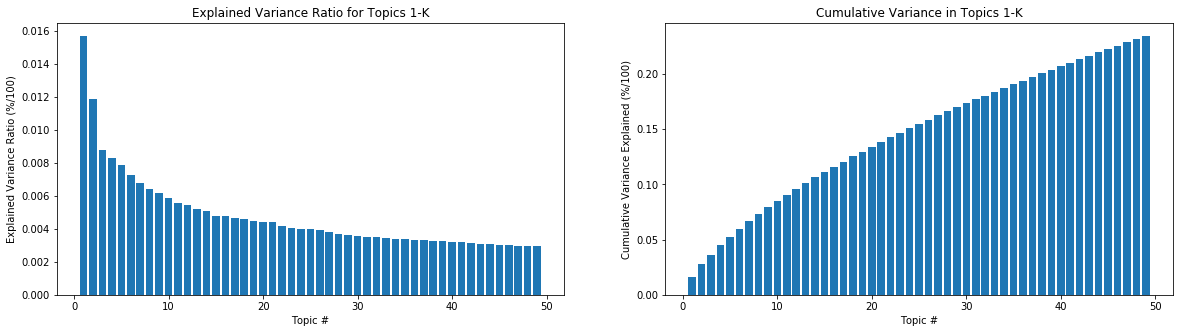

In [93]:
%matplotlib inline
evr = np.array(list(enumerate(svd.explained_variance_ratio_))[:50])
fig = plt.figure(figsize=(20,5))
ax1, ax2 = plt.subplot(121), plt.subplot(122)
ax1.bar(evr[1:,0], evr[1:,1])
ax1.set_title('Explained Variance Ratio for Topics 1-K')
ax1.set_xlabel("Topic #")
ax1.set_ylabel("Explained Variance Ratio (%/100)")
ax2.bar(evr[1:,0], np.cumsum(evr[1:,1]))
ax2.set_title('Cumulative Variance in Topics 1-K')
ax2.set_xlabel("Topic #")
ax2.set_ylabel("Cumulative Variance Explained (%/100)")
plt.show()

<h3> Latent Dirichlet Allocation (LDA) </h3>

We want to discover the top $K$ topics from a corpus of $M$ documents. <b>Latent Dirichlet Allocation</b> is a probabilistic generative model used to discover a vector of "hidden" (latent) topics living among documents in the corpus. We are assuming that in reality the data was generated from the following process:

1. Draw $\mathbf{\theta}_i \sim Dirichlet(\alpha)$ for $i\in \{1, \dots, M\}$
2. Draw $\mathbf{\phi}_k \sim Dirichlet(\beta)$ for $k\in \{1, \dots, K\}$ 

<p>For document $i$, and word position $j$ where $j\in\{1, \dots, N_i\}$, $N_i$ being the number of words in document $i$,</p>

3. Draw a topic $z_{i,j} \sim Multinomial(\mathbf{\theta}_i)$
4. Draw a word $w_{i,j} \sim Multinomial(\mathbf{\phi_{i,j}})$

In [32]:
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)

In [39]:
lda_tf.fit(X_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [40]:
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)

In [41]:
lda_tfidf.fit(X_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [42]:
lda_tfidf_50 = LatentDirichletAllocation(n_components=50, random_state=0)

In [43]:
lda_tfidf_50.fit(X_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=50, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

<h2> V. Evaluation </h2>

<h3>Visualization of LDA</h3>

All credit goes to Carson Sievert and Kenneth E. Shirley for the creation of LDAvis <a href='https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf'>(Sievert and Shirley, 2014)</a>. The tool lets us interactively understand the topics our LDA model generated in the following ways:

https://github.com/cpsievert/LDAvis

1. What is the meaning of each topic?
2. How prevalent is each topic in the overall corpus?
3. How are topics related?

In [44]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [45]:
pyLDAvis.sklearn.prepare(lda_tf, X_tf, count_v)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.196499  0.064218       1        1  9.676340
13    -0.159612  0.048759       2        1  6.718784
0      0.004200 -0.148060       3        1  6.093088
15    -0.116298  0.072321       4        1  5.810337
2     -0.090897 -0.044381       5        1  5.626474
16     0.165724  0.133453       6        1  5.614575
7      0.066146 -0.201035       7        1  5.463630
18    -0.048029  0.151001       8        1  5.365236
11    -0.155349  0.073135       9        1  5.355361
12     0.057161 -0.139293      10        1  5.281771
5      0.206917  0.115566      11        1  5.227008
8     -0.019201 -0.056538      12        1  4.971821
14     0.180660  0.104967      13        1  4.523532
1      0.024201 -0.143343      14        1  4.471068
10     0.111113  0.072732      15        1  3.977801
9      0.160565  0.037723      16        1  3.709016
3     -0.100118  0.014674      17        1  3.450985
17    -0.098879  0.075579      18        1  3.080013
4     -0.084476 -0.106803      19        1  3.001922
6      0.092673 -0.124674      20        1  2.581236, topic_info=           Term           Freq          Total Category  logprob  loglift
411       model  228385.000000  228385.000000  Default  30.0000  30.0000
621      system  135055.000000  135055.000000  Default  29.0000  29.0000
406      method  144552.000000  144552.000000  Default  28.0000  28.0000
19    algorithm   82092.000000   82092.000000  Default  27.0000  27.0000
513     quantum   63541.000000   63541.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
575  simulation    2442.872174   39350.549406  Topic20  -5.0098   0.8776
667       using    3331.364403  106252.873949  Topic20  -4.6996   0.1945
252       field    2734.362828   75669.996002  Topic20  -4.8971   0.3364
547      result    2795.975042  142599.995918  Topic20  -4.8748  -0.2750
567        show    2556.745055  127606.556938  Topic20  -4.9642  -0.2533

[939 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.014799  account
2         2  0.059720  account
2         3  0.064361  account
2         4  0.037391  account
2         5  0.092733  account
...     ...       ...      ...
692      15  0.000793     year
692      17  0.001145     year
692      18  0.031012     year
692      19  0.001322     year
692      20  0.000529     year

[8274 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 14, 1, 16, 3, 17, 8, 19, 12, 13, 6, 9, 15, 2, 11, 10, 4, 18, 5, 7])

In [46]:
pyLDAvis.sklearn.prepare(lda_tfidf, X_tfidf, tfidf_v)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19     0.134886  0.002511       1        1  9.390014
16    -0.100975 -0.162822       2        1  9.084663
17     0.139990 -0.009621       3        1  7.101141
12    -0.056793  0.105514       4        1  6.775485
0     -0.037968  0.113784       5        1  6.261468
18     0.060526 -0.075106       6        1  5.797946
14    -0.102918 -0.108573       7        1  4.831362
13     0.111411  0.019249       8        1  4.787982
5     -0.129760  0.014864       9        1  4.752452
7      0.094533  0.004804      10        1  4.508672
10     0.000264 -0.056702      11        1  4.440625
2      0.047045  0.020264      12        1  4.362425
15    -0.036755  0.094344      13        1  4.139953
4      0.075840  0.018641      14        1  3.680342
1     -0.067220  0.080525      15        1  3.627144
8     -0.047124  0.029839      16        1  3.461592
3      0.040471 -0.017343      17        1  3.314026
9     -0.088373 -0.011785      18        1  3.246964
11     0.026445 -0.097658      19        1  3.243086
6     -0.063526  0.035271      20        1  3.192659, topic_info=         Term         Freq        Total Category  logprob  loglift
296     graph  4963.000000  4963.000000  Default  30.0000  30.0000
513   quantum  6448.000000  6448.000000  Default  29.0000  29.0000
215  equation  5295.000000  5295.000000  Default  28.0000  28.0000
599      star  2854.000000  2854.000000  Default  27.0000  27.0000
278    galaxy  2306.000000  2306.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
547    result   255.780809  8718.160498  Topic20  -5.2367  -0.0845
612     study   238.267895  6764.777777  Topic20  -5.3076   0.0982
406    method   242.712188  9671.278284  Topic20  -5.2891  -0.2407
667     using   232.474562  7173.552185  Topic20  -5.3322   0.0149
567      show   230.868957  8015.772709  Topic20  -5.3392  -0.1030

[971 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.045535  account
2         2  0.017670  account
2         3  0.044176  account
2         4  0.053011  account
2         5  0.088352  account
...     ...       ...      ...
695      16  0.021573     zero
695      17  0.012809     zero
695      18  0.090339     zero
695      19  0.018877     zero
695      20  0.031012     zero

[9332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 17, 18, 13, 1, 19, 15, 14, 6, 8, 11, 3, 16, 5, 2, 9, 4, 10, 12, 7])

In [47]:
pyLDAvis.sklearn.prepare(lda_tfidf_50, X_tfidf, tfidf_v)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
39     0.110249 -0.092946       1        1  9.807595
23     0.048828  0.095716       2        1  4.064249
26     0.092055 -0.078170       3        1  3.261996
5     -0.194419 -0.041844       4        1  2.649481
16    -0.184736 -0.064494       5        1  2.634437
19     0.096629 -0.069377       6        1  2.559927
32    -0.142054 -0.006063       7        1  2.449753
30     0.122617 -0.078674       8        1  2.449655
31     0.071706  0.087873       9        1  2.307890
22     0.048633 -0.071041      10        1  2.252840
18     0.024328 -0.105588      11        1  2.218520
1     -0.007418  0.100723      12        1  2.168755
45    -0.054666 -0.033434      13        1  2.101470
8     -0.165295 -0.048018      14        1  2.077683
12     0.000088  0.026132      15        1  2.061034
36     0.024731  0.094636      16        1  2.052559
0      0.086165  0.070229      17        1  2.034021
17     0.014462 -0.098410      18        1  2.019280
35     0.023740  0.122759      19        1  1.981182
21    -0.097162 -0.023619      20        1  1.900891
47     0.006659  0.151437      21        1  1.861065
20    -0.145266 -0.095268      22        1  1.829509
41     0.087735 -0.022005      23        1  1.782361
11     0.042903 -0.076596      24        1  1.776644
29     0.040834 -0.057027      25        1  1.752538
6     -0.172599 -0.031156      26        1  1.744061
13     0.096935 -0.066442      27        1  1.730500
37    -0.006630  0.132173      28        1  1.725173
2      0.066431 -0.002251      29        1  1.723508
49    -0.086290  0.076756      30        1  1.642726
46     0.064214 -0.083427      31        1  1.595356
4      0.088858 -0.056450      32        1  1.595049
48    -0.045466 -0.088563      33        1  1.576285
14    -0.141785 -0.033973      34        1  1.534313
34     0.020644  0.108095      35        1  1.526087
27     0.010225  0.064345      36        1  1.519777
44     0.021841  0.108151      37        1  1.510754
9     -0.015144  0.078849      38        1  1.500529
42     0.014156  0.109494      39        1  1.500215
24     0.032516 -0.048061      40        1  1.477956
10    -0.046113  0.080255      41        1  1.463459
28     0.037930  0.007462      42        1  1.343706
7      0.034280  0.056708      43        1  1.292724
33    -0.055383  0.106461      44        1  1.287322
25     0.089186 -0.051961      45        1  1.184704
15     0.013089  0.021492      46        1  1.179656
38    -0.045990 -0.063169      47        1  1.103235
40     0.036298 -0.070899      48        1  1.097969
43    -0.023443  0.005857      49        1  1.051698
3      0.060895 -0.046677      50        1  1.037899, topic_info=            Term         Freq        Total Category  logprob  loglift
296        graph  4868.000000  4868.000000  Default  30.0000  30.0000
513      quantum  6549.000000  6549.000000  Default  29.0000  29.0000
18       algebra  2577.000000  2577.000000  Default  28.0000  28.0000
425      network  7527.000000  7527.000000  Default  27.0000  27.0000
395       matrix  3514.000000  3514.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
444          one    71.930151  5541.563975  Topic50  -5.3817   0.2236
467  performance    68.407374  4533.449567  Topic50  -5.4319   0.3742
496      problem    73.597187  7811.106718  Topic50  -5.3588  -0.0967
637         time    70.992146  6280.414218  Topic50  -5.3948   0.0853
547       result    68.844728  8773.576947  Topic50  -5.4255  -0.2797

[2388 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.223864  ability
0         2  0.015177  ability
0         3  0.066400  ability
0         6  0.132801  ability
0         8  0.034149  ability
...     ...       ...      ...
695      46  0.003283     zero
695      47  0.017070     zero
695      48  

<h2> VI. Potential Improvements </h2>

<h3> Text Processing </h3>


- Consider adding n-grams
- Better lemmatization than NLTK (SpaCy is closer to production-grade, but more expensive)

<h3> Modeling </h3>

- Linear space is far too simple to understand complexities of language. Neural networks can do a better job capturing the complexity that comes with understanding context. 

<h3> Further Questions </h3>

- Consider the tree formed by each topic as root node. What does that hierarchy look like? How to break a topic like ML into K latent sub-topics? What can we learn generally about the dependence structure of topics by recursing down to the end of this tree? (If I understand the content of a node/topic, I must understand the subtopics)